# Epidemble Example Notebook
In this Notebook we give an overview of the main features of Epiedmble. The contents of this notebook are the following:
1. we study the Bayes Optimal conditions, so we infer with the same hyper-parameters of the prior. We use Epidemble to obtain marginals and AUC. 
2. Then we move to a comparison with Belief Propagation on large graphs. We must check that everything is consistent with the results of point 1, since Epidemble is based on replica symmetric cavity method, which is Belief Propagation for the infinite graph. 
3. After that, we make a sweep on hyper-parameters in order to obtain phase diagrams with Epidemble. These phase diagrams quantify hardness of inference in terms of the hyper-parameters. 
4. We move to inference of hyper-parameters, which is a crucial task for practical applications. We show how to set the variables to infer hyper-parameters

In the next cell, we start by importing the source code.

In [17]:
import OffsetArrays
using Plots
using Revise
using StatsBase
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using Distributions
srcpath = "./src"
include("$srcpath/bp.jl") #julia code which contains the bp update
include("$srcpath/post_infer.jl") #definition of the main functions and the types
include("$srcpath/observables.jl") # julia code for estimating observables

avg_ninf (generic function with 1 method)

## Epidemble in Bayes Optimal Conditions

In [2]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.2# planted infection rate
λi = 0.2 #inferred infection rate

infer_lam = false #set it true if you want to infer the prior parameter λ
infer_gam = false #set it true if you want to infer the prior parameter γ


T = 8 # discrete time: number of time-steps

γp = 0.1 # planted autoinfection probability
γi = 0.1 # inferred autoinfection probability

N = 5000; #population size
dilution = 0.0 #dilution of observations. dil=0 means everybody observed once
fr = 0.0; #noise in the observation. 


In [3]:
degree_dist = Dirac(3) #the distribution of the degree in the graph. Dirac means random regular.

Dirac{Int64}(value=3)

In [4]:
#now we initialize the model. We need to provide:
#Population size N: the higher N the higher the precision
#The total number of time steps T
# The parameter γp which is the planted parameter for patiet zero self infection
# The λp which is the planted infection
# γi and λi, the patient zero self infection and the infection used to make inference
# the false rate and observation dilution
#for other optional fields, see documentation.
M = ParametricModel(N = N, T = T, γp = γp, λp = λp, γi=γi, λi=λi + δλ(infer_lam), fr=fr, dilution=dilution, distribution=degree_dist) ;

In [5]:
#we run the cavity method which updates the population of messages and returns the free energy and the total number of iterations
F,it = pop_dynamics(M, tot_iterations = 40, eta = 0.1, infer_lam=infer_lam, infer_gam=infer_gam);

In [6]:
marg = M.belief |> real;
marg2D = reshape(sum(marg,dims=3) ./ N, T+2,T+2)
ensAUC = avgAUC(marg,M.obs_list,count_obs=true); #set false to see the AUC only on NON observed indiv.

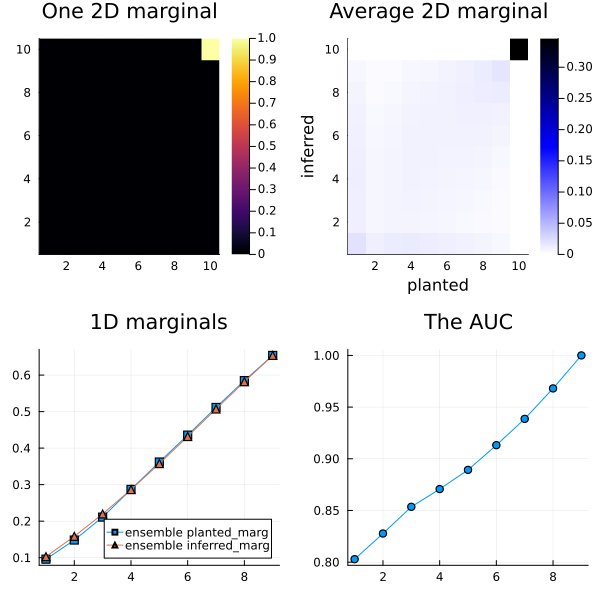

In [7]:
p1 = heatmap(reshape((marg[:,:,rand(1:N)]),T+2,T+2),title="One 2D marginal")
p2 = plot(ensAUC,label="ens_AUC",marker=:c,legend=false,title="The AUC")
pheat = heatmap((marg2D),c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average 2D marginal")
p0 = plot(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),marker=:square,label="ensemble planted_marg",title="1D marginals")
p0 = plot!(cumsum(sum(marg2D,dims=2)[1:end-1],dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
plot(p1,pheat,p0,p2,size=(600,600))

# Single Instance Inferernce with Sib

We compare ensemble results (i.e. infinite graph) with single instance results for large graphs. We need to sample a planted configuration, observe this configuration at final time and infere the single instance. We do this many times and we average so to compare with the ensemble results

### Check of the planted distribution
Here we check with a sampler and with sibyl that the planted ensemble marginal is correct.

In [8]:
include("$srcpath/single_instance.jl")

build_real_graph (generic function with 1 method)

In [9]:
Ngraph = 20000 # size of the single instance graph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory
# First we initialize a single instance marginal y
# which will be the average over graph and particles
# and epidemic trajectory of the marginals
y = zeros(T+1)
yBPp = zero(y)
# we average over totst iterations
totst = 1
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = makeGraph(Ngraph,degree_dist)
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # we calculate the cumulative marginal (non-normalized)
    # and we sum it to the average marginal
    y .+= sum(x,dims=1)'
    p_sib = sibyl(Ngraph, T+1, G, [], γp, λp; maxit = 40, tol = 1e-2);
    avgmarg = sum(p_sib,dims=1)' ./ Ngraph
    yBPp .+= avgmarg
end
#we normalize the average marginal
y ./= (Ngraph * totst)
yBPp ./=  totst;

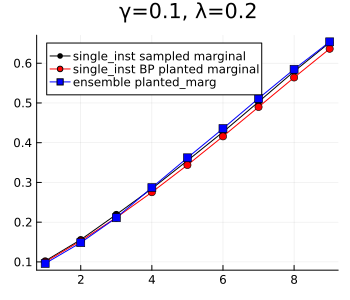

In [10]:
p0 = plot(y,c=:black,marker=:circle,label="single_inst sampled marginal",title="γ=$γp, λ=$λp")
p0 = plot!(yBPp,c=:red,marker=:circle,label="single_inst BP planted marginal")
p0 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)

Here we check instead the results for the inferred marginal

In [18]:
yBP = zeros(T+1)
totst = 1
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = makeGraph(Ngraph,degree_dist)
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # observations set in the form of 
    # [(individual,state,observation time, false_rate of the test)]
    # where state ∈ {0,1} respectively for S and I
    # The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
    # Instead the ensemble goes from time 0 to time T  
    O = [(i,Bool(x[i,T+1]),T+1,1e-10) for i = 1:Int(round(Ngraph * (1 - dilution)))]
    O = [rand() > fr ? (o[1],o[2],o[3],fr) : (o[1],!o[2],o[3],fr) for o in O]
    #we now run the BP algorithm for the single instance defined above
    p_sib = sibyl(Ngraph, T+1, G, O,  γi , λi; maxit = 200, tol = 1e-2);
    yBP .+= sum(p_sib,dims=1)'
end

yBP ./= (Ngraph * totst);

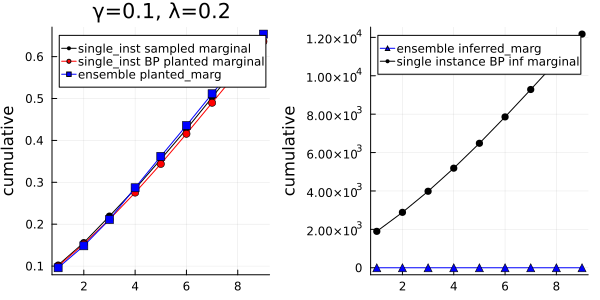

In [12]:
p1 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:blue,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p1 = plot!(yBP,c=:black,marker=:circle,label="single instance BP inf marginal")
plot(p0,p1,size=(600,300),ylabel="cumulative",legend=:topleft)
#savefig("sibVSepid")

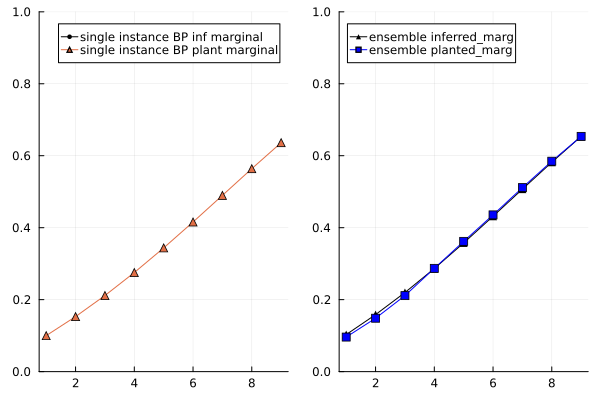

In [13]:
p2 = plot(yBP,c=:black,marker=:circle,label="single instance BP inf marginal")
p2 = plot!(yBPp,marker=:utriangle,label="single instance BP plant marginal")
p3 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:black,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p3 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)
plot(p2,p3,ylim=(0,1))

## 2D marginal comparison

In [14]:
function cumulate(cdf_sib)
    N, T = size(cdf_sib) 
    p = zeros(N,T+1)
    p[:,1] .= cdf_sib[:,1]
    for t = 1:T-1
        p[:,t+1] .= cdf_sib[:,t+1] .- cdf_sib[:,t]
    end
    p[:,T+1] .= 1 .- cdf_sib[:,T]
    return p
end

cumulate (generic function with 1 method)

In [15]:
AUC = zeros(T+1)
AUCerr = zeros(T+1)
AUC =  zeros(T+1)
sibylmarg2D = zeros(T+2,T+2)
totst = 1
mse = 0
@showprogress for st = 1:totst
    G = makeGraph(Ngraph,degree_dist)
    sample!(x, G, λp, γp)
    O = [(i,Bool(x[i,T+1]),T+1,1e-10) for i = 1:Int(round(Ngraph * (1 - dilution)))]
    O = [rand() > fr ? (o[1],o[2],o[3],fr) : (o[1],!o[2],o[3],fr) for o in O]
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-100);
    sib_pdf = cumulate(p_sib)
    mse = siMSE(x, p_sib)
    for t = 1:T+1
        AUC[t] += AUROC(ROC(x[:,t], p_sib[:,t]))
        AUCerr[t] += AUROC(ROC(x[:,t], p_sib[:,t]))^2
    end
    tau = T .- sum(x,dims=2) .+ 2; #set of planted times
    for τ = 1:T+2
        # We take the pdf only for individuals infected at time τ 
        sibylmarg2D[:,τ] .+= sum(sib_pdf .* (tau .== τ ),dims=1)' 
    end
    sing_inst_marg = zeros(Ngraph, T+2, T+2)
    for l = 1:Ngraph
        sing_inst_marg[l,:,tau[l]] .= sib_pdf[l,:] 
    end
    sing_inst_marg = OffsetArrays.OffsetArray(sing_inst_marg,0,-1,-1);
end
AUC ./= totst 
AUCerr .= sqrt.((AUCerr./ totst  .- (AUC .^ 2))./ totst ) 
sibylmarg2D ./= (Ngraph*totst);

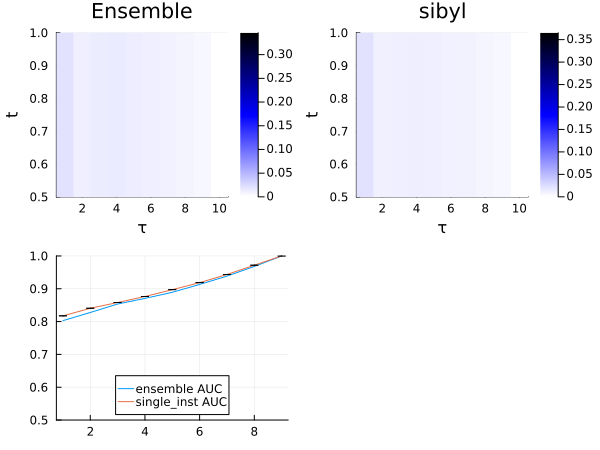

In [16]:
plot_sib = heatmap(sibylmarg2D,c=[:white,:blue,:black],xlabel="τ",ylabel="t",title="sibyl") 
plot_ens = heatmap(marg2D,c=[:white,:blue,:black],xlabel="τ",ylabel="t",title="Ensemble")
pAUC = plot(ensAUC,label="ensemble AUC")
#pAUC = plot(avgAUC(marg),label="ensemble AUC")
pAUC = plot!(AUC,label="single_inst AUC",legend=:topleft,yerr=AUCerr)
plot(plot_ens,plot_sib,pAUC,size = (600,450),ylims=(0.5,1.0),legend=:bottom)
#savefig("ensemble_VS_sibyl")

# Obtaining Phase Diagrams with Epidemble